<a href="https://colab.research.google.com/github/keerthanab2201/Sentiment-Analysis-using-Deep-Learning/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Collection
(E-Commerce product reviews from Amazon in JSON format)

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load csv file and preview
df= pd.read_csv("/content/drive/MyDrive/datasets/Amazon-Product-Reviews-Sentiment-Analysis-in-Python-Dataset.csv")
print(df.head())

                                              Review  Sentiment
0  Fast shipping but this product is very cheaply...          1
1  This case takes so long to ship and it's not e...          1
2  Good for not droids. Not good for iPhones. You...          1
3  The cable was not compatible between my macboo...          1
4  The case is nice but did not have a glow light...          1


In [ ]:
# Save as a JSON file(records format)
df.to_json("amazon_reviews_data.json", orient="records", lines=True)
print("✅ Conversion complete: Saved as reviews_data.json")

✅ Conversion complete: Saved as reviews_data.json


##Data Pre-Processing
- lowercase
- stopword removal
- punctuation removal
- one word review removal
- contraction removal
- tokenization
- part of speech tagging

In [ ]:
# installing dependencies
!pip install contractions textblob gensim beautifulsoup4
!python -m textblob.download_corpora

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Step 2: Import Modules
import re
import pandas as pd
import nltk
import numpy as np
import gensim
from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from contractions import fix as expand_contractions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [ ]:
# load JSON dataset and inspect columns
df = pd.read_json("amazon_reviews_data.json", lines=True)
print(df.columns)


Index(['Review', 'Sentiment'], dtype='object')


In [ ]:
# Drop missing values and filter required columns
text_col = "Review"
label_col = "Sentiment"
df = df[[text_col, label_col]].dropna() #these are the two columns
df.columns = ["text", "rating"]  # Normalize column names

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Define preprocessing function
def preprocess_pipeline(text):
    text = str(text)

    # 1. Lowercasing
    text = text.lower()

    # 2. Stopword Removal
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]

    # 3. Remove Punctuation
    tokens = [re.sub(r"[^\w\s]", "", t) for t in tokens]
    tokens = [t for t in tokens if t.strip() != ""]

    # Rejoin tokens for further steps
    text = " ".join(tokens)

    # 4. Remove One-Word Reviews
    if len(tokens) <= 1:
        return None

    # 5. Contraction Removal
    text = expand_contractions(text)

    # 6. Tokenization (again)
    tokens = word_tokenize(text)

    # 7. Part-of-Speech (POS) Tagging
    pos_tags = nltk.pos_tag(tokens)

    # 8. Score Generation using TextBlob Sentiment
    polarity_score = TextBlob(text).sentiment.polarity  # -1 to 1

    return {
        "clean_text": text,
        "tokens": tokens,
        "pos_tags": pos_tags,
        "score": polarity_score
    }

In [ ]:
# Apply preprocessing function

processed = df["text"].apply(preprocess_pipeline)
df = df[processed.notnull()].copy()
df["processed"] = processed[processed.notnull()].values



In [ ]:
# Extract cleaned data for tokenization
texts = df["processed"].apply(lambda x: x["clean_text"]).tolist()
labels = df["rating"].tolist()
scores = df["processed"].apply(lambda x: x["score"]).tolist()
# Result: Three lists containing the text data, labels, and scores respectively

In [ ]:
# 9. Word Embeddings
# Keras Tokenizer- converts raw text into numerical sequences (each word= unique integer index) that can be later processed by Keras layers like Embedding
MAX_VOCAB = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
# sequence padding- adding placeholder values (often zeros) to shorter sequences in a dataset to make them all the same length
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post')


In [ ]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/glove.6B.zip", "r") as zip_ref:
    zip_ref.extractall("glove")

In [ ]:
# Load GloVe and Create Embedding Matrix
#GloVe(Global Vectors for Word Representation)- converts words into numerical vectors(embeddings) that capture semantic relationships between words- unsupervised learning algorithm

embedding_index = {}
with open("glove/glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")[:50]  # ← Truncate to 50D
        embedding_index[word] = coefs

embedding_dim = 50  # matching model spec
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


##CNN Model

In [ ]:
# Remove neutral reviews and relabel
df = df[df['rating'] != 3]
df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0) # creates binary labels: 1 for positive (rating ≥4), 0 for negative

/tmp/ipython-input-29-3232871527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0) # creates binary labels: 1 for positive (rating ≥4), 0 for negative


In [ ]:
# Get cleaned texts again
texts = df["processed"].apply(lambda x: x["clean_text"]).tolist()
labels = df["label"].tolist()

In [ ]:
# Prepare tokenizer and sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [ ]:
vocab_size = 15000
input_length = 400
# creates vocabulary of 15,000 most frequent words, converts text to integer sequences and pads sequences to length 400 (truncating longer texts or padding shorter ones)

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
padded_sequences = pad_sequences(sequences, maxlen=input_length, padding='post')

word_index = tokenizer.word_index

In [ ]:
# setup embedding matrix
# initializes embedding matrix with zeros and fill it with pre-trained GloVe vectors where available
embedding_dim = 50
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# train test split- 80/20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# assign hyperparameters
embedding_dim = 50
num_filters = 64
kernel_size = 3
strides = 5
pool_size = 5
dropout_rate = 0.4

In [ ]:
# build CNN model
cnn_model = Sequential()
'''Embedding layer- Converts word indices to dense vectors
                  -Initialized with GloVe embeddings (50 dimensions) '''
cnn_model.add(Embedding(input_dim=len(word_index)+1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix[:, :embedding_dim]],
                        input_length=input_length,
                        trainable=True))
'''ID Convolutional layer- Scans text with 64 filters, each detecting 3-word patterns (n-grams)
                         - strides=5 means it jumps 5 words between applications (reduces computation)
                         - ReLU activation highlights important features '''
cnn_model.add(Conv1D(filters=64, kernel_size=3, strides=5, activation='relu'))
'''MaxPooling1D layer- downsamples by taking maximum value in 5-word windows
                     - reduces sequence length while keeping most important features '''
cnn_model.add(MaxPooling1D(pool_size=5))
'''GlobalMaxPooling1D layer- takes maximum value across the entire sequence
                           - converts variable-length output to fixed-size vector (critical for classification) '''
cnn_model.add(GlobalMaxPooling1D())
'''Dropout Layer- randomly drops 40% of neurons during training
                - prevents overfitting by forcing redundant feature learning '''
cnn_model.add(Dropout(0.4))
'''Dense layer(64 units)- standard neural network layer for higher-level feature combination
                        - ReLU activation adds non-linearity '''
cnn_model.add(Dense(64, activation='relu'))
'''Output Layer (Dense with sigmoid)- Single neuron with sigmoid activation
                                    - Outputs probability between 0 (negative) and 1 (positive)'''
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)


In [ ]:
# define early stopping function
from keras.callbacks import EarlyStopping

# early stopping- regularization technique to prevent overfitting by halting the training process when the model's performance on a validation set starts to degrade
early_stop_cnn = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [ ]:
# Train CNN model with early stopping
history_cnn = cnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[early_stop_cnn],
    verbose=1
)


Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6055 - loss: 0.6530 - val_accuracy: 0.7796 - val_loss: 0.4748
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.7796 - loss: 0.4619 - val_accuracy: 0.8089 - val_loss: 0.4171
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8385 - loss: 0.3621 - val_accuracy: 0.8194 - val_loss: 0.3920
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8850 - loss: 0.2905 - val_accuracy: 0.8239 - val_loss: 0.3933
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9064 - loss: 0.2432 - val_accuracy: 0.8189 - val_loss: 0.4084


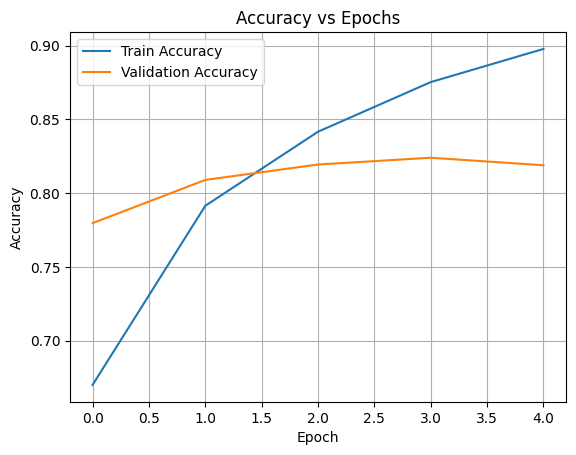

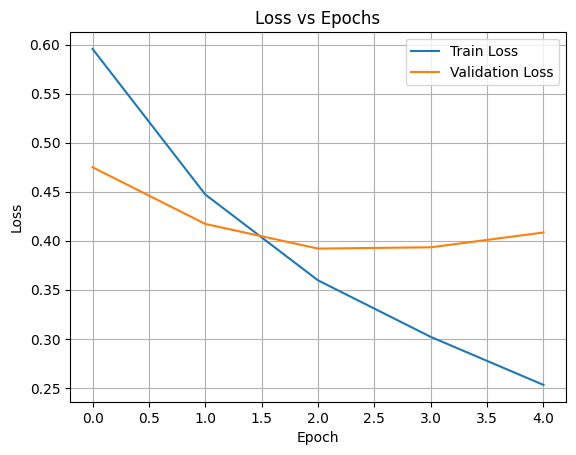

In [ ]:
# plot accuracy and loss vs epoch
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, np.array(labels), test_size=0.2, random_state=42)


In [ ]:
# Predict probabilities on test set
y_pred_prob = cnn_model.predict(X_test)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion matrix and specificity
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Print results
print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Specificity  : {specificity:.4f}")


Confusion Matrix:
[[1582  410]
 [ 299 1634]]

Accuracy     : 0.8194
Precision    : 0.7994
Recall       : 0.8453
F1 Score     : 0.8217
Specificity  : 0.7942


##CNN-LSTM Model

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

In [63]:
# Model Parameters
embedding_dim = 50
input_length = 400
vocab_size = len(word_index) + 1
num_filters = 64
kernel_size = 3
strides = 5
pool_size = 5
lstm_units = 50
dropout_rate = 0.4

In [71]:
# Build CNN-LSTM Model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Embedding(input_dim=vocab_size,
                             output_dim=embedding_dim,
                             weights=[embedding_matrix],
                             input_length=input_length,
                             trainable=True))
cnn_lstm_model.add(Dropout(dropout_rate))
cnn_lstm_model.add(Conv1D(filters=num_filters,
                          kernel_size=kernel_size,
                          strides=strides,
                          activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=pool_size))
cnn_lstm_model.add(LSTM(units=lstm_units))
cnn_lstm_model.add(Dense(64))
cnn_lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [72]:
# Compile
cnn_lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    # Watch validation loss
    patience=2,            # Stop after 2 epochs without improvement
    restore_best_weights=True
)

In [74]:
# Train with early stopping
history_cnn_lstm = cnn_lstm_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.6082 - loss: 0.6357 - val_accuracy: 0.7847 - val_loss: 0.4735
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.7810 - loss: 0.4640 - val_accuracy: 0.7982 - val_loss: 0.4280
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.8233 - loss: 0.3978 - val_accuracy: 0.8278 - val_loss: 0.3941
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8496 - loss: 0.3484 - val_accuracy: 0.8298 - val_loss: 0.3859
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8627 - loss: 0.3266 - val_accuracy: 0.8265 - val_loss: 0.3943
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.8734 - loss: 0.2997 - val_accuracy: 0.8329 - val_loss: 0.3886


In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Predict on test data
y_pred_prob_lstm = cnn_lstm_model.predict(X_test)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int).flatten()

# Confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
tn, fp, fn, tp = cm_lstm.ravel()
specificity_lstm = tn / (tn + fp)

# Classification metrics
accuracy = accuracy_score(y_test, y_pred_lstm)
precision = precision_score(y_test, y_pred_lstm)
recall = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)

# Print results
print("Confusion Matrix (CNN-LSTM):")
print(cm_lstm)
print(f"\nAccuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Specificity  : {specificity_lstm:.4f}")


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix (CNN-LSTM):
[[1624  368]
 [ 300 1633]]

Accuracy     : 0.8298
Precision    : 0.8161
Recall       : 0.8448
F1 Score     : 0.8302
Specificity  : 0.8153


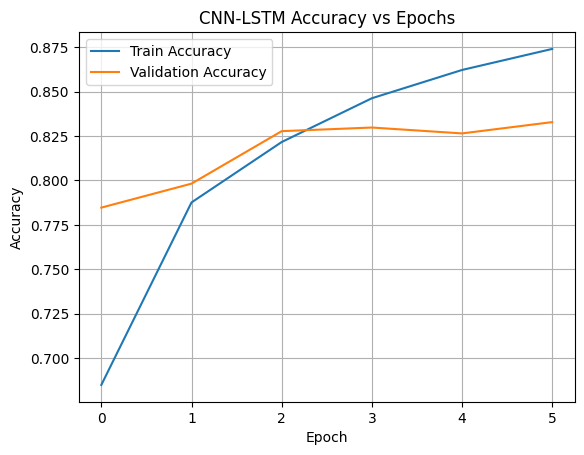

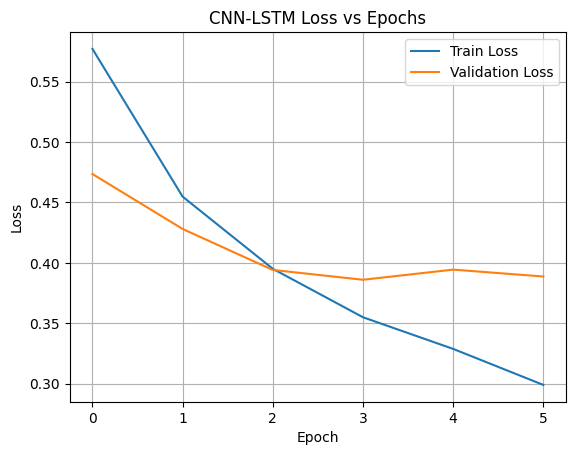

In [76]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history_cnn_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history_cnn_lstm.history['loss'], label='Train Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


##LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [ ]:
# Model hyperparameters
embedding_dim = 50
input_length = 200
lstm_units = 50
dropout_rate = 0.4
batch_size = 32
epochs = 15


In [ ]:
# Define early stopping
early_stop_lstm = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [ ]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(word_index) + 1,
                         output_dim=embedding_dim,
                         weights=[embedding_matrix],
                         input_length=input_length,
                         trainable=True))
lstm_model.add(Bidirectional(LSTM(50, return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(50)))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile model
lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [59]:
# Train model
history_lstm = lstm_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stop_lstm],
    verbose=1
)

Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 435s 871ms/step - accuracy: 0.7105 - loss: 0.5550 - val_accuracy: 0.8290 - val_loss: 0.3867
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 437s 861ms/step - accuracy: 0.8582 - loss: 0.3281 - val_accuracy: 0.8538 - val_loss: 0.3384
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 420s 815ms/step - accuracy: 0.9089 - loss: 0.2487 - val_accuracy: 0.8617 - val_loss: 0.3584
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 437s 807ms/step - accuracy: 0.9254 - loss: 0.2060 - val_accuracy: 0.8594 - val_loss: 0.3688


In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Predict probabilities and class labels
y_pred_prob_lstm = lstm_model.predict(X_test)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int).flatten()

# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
tn, fp, fn, tp = cm_lstm.ravel()
specificity_lstm = tn / (tn + fp)

# Metrics
accuracy = accuracy_score(y_test, y_pred_lstm)
precision = precision_score(y_test, y_pred_lstm)
recall = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)

# Display Results
print("Confusion Matrix (LSTM):")
print(cm_lstm)
print(f"\nAccuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Specificity  : {specificity_lstm:.4f}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step
Confusion Matrix (LSTM):
[[1680  312]
 [ 262 1671]]

Accuracy     : 0.8538
Precision    : 0.8427
Recall       : 0.8645
F1 Score     : 0.8534
Specificity  : 0.8434


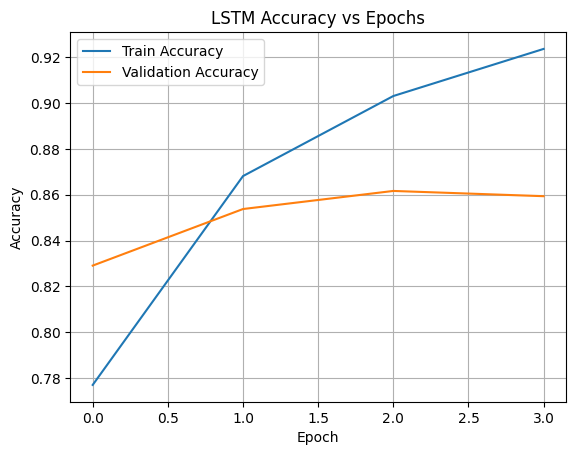

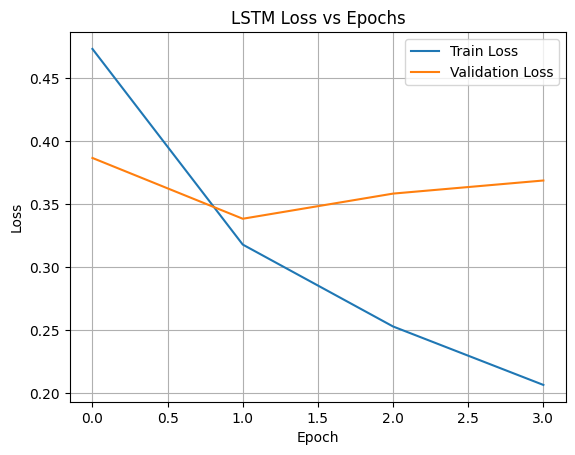

In [61]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


{0: 7909, 1: 7790}


In [77]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
